# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
import torch
import time

The device to use:  cuda:0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux_20/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]



### 3. Train the agents with DDPG



In [5]:
def ddpg(n_episodes=200, max_t = 1000):
    scores_deque = deque(maxlen=100)
    scores = []
    mean_scores_1episode=[]
    mean_scores_100episode=[]
    max_score = -np.Inf
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros((num_agents,))
        
        start_time = time.time()
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations       # get next state (for each agent)
            reward = env_info.rewards                       # get reward (for each agent)
            done = env_info.local_done                      # see if episode finished
            score += np.array(env_info.rewards)             # update the score (for each agent)    
            agent.step(state, action, reward, next_state, done, t)
            state = next_state
            
            if np.any(done):
                break

        end_time = time.time()
        scores_deque.append(score)
        scores.append(score)
        mean_scores_1episode.append(np.mean(score))
        mean_scores_100episode.append(np.mean(scores_deque))

        print('\rMean Score in Episode {:03d}: {:.2f}, \tMean Score over last 100 episodes: {:.2f} ({:.1f} secs)'.format(i_episode,np.mean(score), np.mean(scores_deque), end_time-start_time), end="\n")
        
        if np.mean(scores_deque) > 30 and i_episode >=100:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score over last 100 episodes: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            return scores, mean_scores_1episode, mean_scores_100episode
     
    return scores, mean_scores_1episode, mean_scores_100episode

agent = Agent(state_size, action_size, random_seed=0)
scores, mean_scores_1episode, mean_scores_100episode = ddpg()



Mean Score in Episode 001: 0.55, 	Mean Score over last 100 episodes: 0.55 (15.3 secs)
Mean Score in Episode 002: 0.16, 	Mean Score over last 100 episodes: 0.36 (14.6 secs)
Mean Score in Episode 003: 0.06, 	Mean Score over last 100 episodes: 0.26 (14.9 secs)
Mean Score in Episode 004: 0.11, 	Mean Score over last 100 episodes: 0.22 (15.1 secs)
Mean Score in Episode 005: 0.30, 	Mean Score over last 100 episodes: 0.24 (14.8 secs)
Mean Score in Episode 006: 0.25, 	Mean Score over last 100 episodes: 0.24 (15.0 secs)
Mean Score in Episode 007: 1.24, 	Mean Score over last 100 episodes: 0.38 (15.2 secs)
Mean Score in Episode 008: 1.69, 	Mean Score over last 100 episodes: 0.55 (15.2 secs)
Mean Score in Episode 009: 2.71, 	Mean Score over last 100 episodes: 0.79 (16.4 secs)
Mean Score in Episode 010: 3.73, 	Mean Score over last 100 episodes: 1.08 (16.7 secs)
Mean Score in Episode 011: 4.56, 	Mean Score over last 100 episodes: 1.40 (17.1 secs)
Mean Score in Episode 012: 7.64, 	Mean Score over last

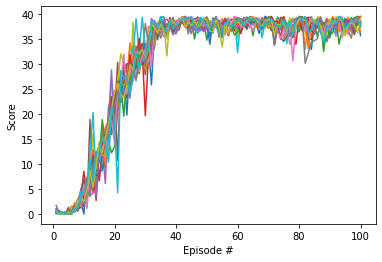

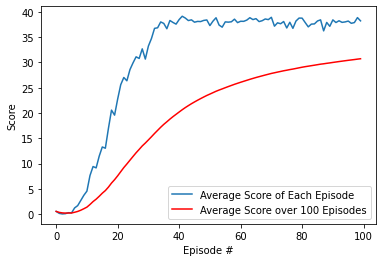

In [6]:
# plot the scores of every agent
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# plot the average scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), mean_scores_1episode, label='Average Score of Each Episode')
plt.plot(np.arange(len(scores)), mean_scores_100episode, c='r', label='Average Score over 100 Episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='lower right')
plt.show()

When finished, you can close the environment.

In [7]:
env.close()


```